In [1]:
# IMPORT LIBRARY
import pandas as pd                      # Untuk manipulasi data tabel (DataFrame)
import numpy as np                       # Untuk operasi numerik
import re                                # Untuk regular expression (cleaning teks)
import string                            # Untuk operasi string, misal hapus tanda baca
import nltk                              # Natural Language Toolkit, untuk teks processing
import tensorflow as tf                  # Framework deep learning
from sklearn.model_selection import train_test_split  # Untuk split data training dan testing
from sklearn.preprocessing import LabelEncoder        # Untuk encoding label (kelas) menjadi angka
from sklearn.utils import resample                     # Untuk upsampling data minoritas
from tensorflow.keras.preprocessing.text import Tokenizer      # Untuk membuat token dari teks
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Untuk padding sequence agar panjang sama
from tensorflow.keras.models import Sequential       # Untuk membangun model neural network sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional  # Layer-layer neural network
from nltk.corpus import stopwords                  # Stopwords bahasa Indonesia
import matplotlib.pyplot as plt                    # Untuk visualisasi grafik

nltk.download('stopwords')  # Mengunduh stopwords bahasa Indonesia

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# BACA DATASET
file_path = "dataset_tweet_sentiment_pilkada_DKI_2017.csv"  # Path file CSV dataset
data = pd.read_csv(file_path)                                 # Membaca dataset menjadi DataFrame
data = data[['Text Tweet', 'Sentiment']].dropna()            # Ambil kolom 'Text Tweet' dan 'Sentiment', hapus baris kosong


In [3]:
# CLEANING TEKS
stop_words = set(stopwords.words('indonesian'))  # Ambil daftar stopwords bahasa Indonesia
important_words = {"tidak", "bukan", "ga", "nggak", "enggak"}  # Kata penting yang jangan dihapus
stop_words = stop_words - important_words       # Hapus kata penting dari daftar stopwords

def clean_text(text):                            # Fungsi untuk membersihkan teks
    text = text.lower()                          # Ubah semua teks menjadi huruf kecil
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Hapus link/URL
    text = re.sub(r'@\w+|#\w+', '', text)                # Hapus mention dan hashtag
    text = re.sub(r'(agus|silvy|anies|sandi|ahok|djarot)', '', text)  # Hapus nama kandidat
    text = re.sub(r'[^a-zA-Z\s]', '', text)              # Hapus karakter non-alfabet
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca
    tokens = text.split()                                # Pisahkan teks menjadi kata/token
    tokens = [w for w in tokens if w not in stop_words]  # Hapus stopwords
    return " ".join(tokens)                              # Gabungkan kembali menjadi string

data['clean_text'] = data['Text Tweet'].astype(str).apply(clean_text)  # Terapkan cleaning ke seluruh dataset


In [4]:
# Encoding Label
label_encoder = LabelEncoder()                 # Buat encoder label
data['label'] = label_encoder.fit_transform(data['Sentiment'])  # Ubah kelas sentiment menjadi angka (0 atau 1)


In [5]:
# Balancing Dataset
df_majority = data[data['label'] == data['label'].mode()[0]]      # Ambil kelas mayoritas
df_minority = data[data['label'] != data['label'].mode()[0]]      # Ambil kelas minoritas

df_minority_upsampled = resample(                                 # Upsampling kelas minoritas
    df_minority,
    replace=True,                                                  # Sampling dengan pengembalian
    n_samples=len(df_majority),                                    # Samakan jumlah dengan kelas mayoritas
    random_state=42                                                # Seed agar hasil konsisten
)

data_balanced = pd.concat([df_majority, df_minority_upsampled])   # Gabungkan kembali menjadi dataset seimbang


In [6]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(               # Split data menjadi training dan testing
    data_balanced['clean_text'], data_balanced['label'],
    test_size=0.2,                                                 # 20% untuk testing
    random_state=42
)

In [7]:
# Tokenizer dan Padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # Buat tokenizer, maksimal 10000 kata, OOV untuk kata tidak dikenal
tokenizer.fit_on_texts(X_train)                             # Fit tokenizer ke data training

X_train_seq = tokenizer.texts_to_sequences(X_train)         # Konversi teks training menjadi sequence angka
X_test_seq = tokenizer.texts_to_sequences(X_test)           # Konversi teks testing menjadi sequence angka

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')  # Padding sequence training
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')    # Padding sequence testing


In [8]:
# MODEL BIDIRECTIONAL LSTM
model = Sequential([
    Embedding(input_dim=10000, output_dim=128),               # Embedding layer, representasi kata menjadi vektor 128 dimensi
    Bidirectional(LSTM(128, return_sequences=False)),         # LSTM dua arah dengan 128 unit
    Dropout(0.3),                                             # Dropout 30% untuk mencegah overfitting
    Dense(64, activation='relu'),                              # Dense layer 64 unit, ReLU activation
    Dense(1, activation='sigmoid')                             # Output layer 1 unit, sigmoid untuk binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Kompilasi model

model.build(input_shape=(None, max_len))  # Build model agar input shape jelas (None = batch size fleksibel)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,559,681 (5.95 MB)

 Trainable params: 1,559,681 (5.95 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Training
history = model.fit(
    X_train_pad, y_train,
    epochs=20,                 # Latih 20 epoch
    batch_size=32,             # Batch size 32
    validation_split=0.2,      # 20% data training untuk validasi
    verbose=1                  # Tampilkan progress training
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step - accuracy: 0.5253 - loss: 0.6916 - val_accuracy: 0.4931 - val_loss: 0.6959
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 302ms/step - accuracy: 0.5668 - loss: 0.6672 - val_accuracy: 0.5764 - val_loss: 0.6543
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 400ms/step - accuracy: 0.7839 - loss: 0.5228 - val_accuracy: 0.7708 - val_loss: 0.4709
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 318ms/step - accuracy: 0.9281 - loss: 0.1760 - val_accuracy: 0.7500 - val_loss: 0.5102
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.9943 - loss: 0.0457 - val_accuracy: 0.7569 - val_loss: 0.5693
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 399ms/step - accuracy: 0.9882 - loss: 0.0306 - val_accuracy: 0.8056 - val_loss: 0.5616
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.9911 - loss: 0.0178 - val_accuracy: 0.7778 - val_loss: 0.6348
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.9956 - loss: 0.0156 - val_accuracy:

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7735 - loss: 0.8941

Akurasi Data Uji: 0.7722
Loss Data Uji: 0.8320


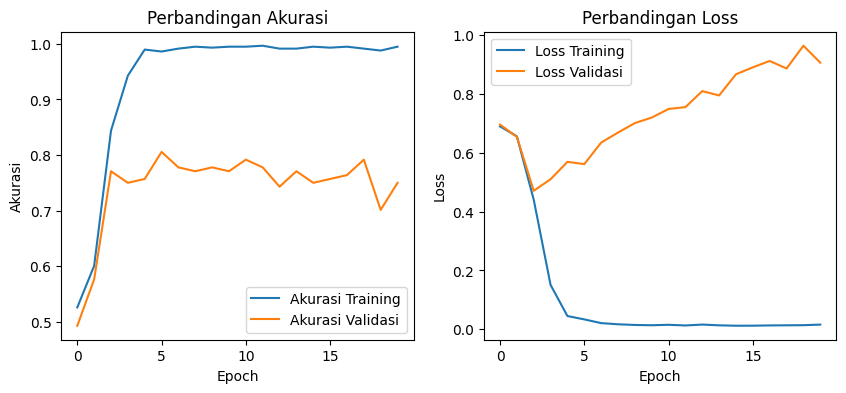

In [10]:
# Evaluasi
loss, acc = model.evaluate(X_test_pad, y_test, verbose=1)  # Evaluasi model dengan data testing
print(f"\nAkurasi Data Uji: {acc:.4f}")                  # Tampilkan akurasi
print(f"Loss Data Uji: {loss:.4f}")                      # Tampilkan loss

# Menampilkan visualisasi hasil Training
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Akurasi Training')       # Plot akurasi training
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')  # Plot akurasi validasi
plt.title('Perbandingan Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss Training')              # Plot loss training
plt.plot(history.history['val_loss'], label='Loss Validasi')          # Plot loss validasi
plt.title('Perbandingan Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
